In [1]:
#### Import librairies
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import collections
from importlib import reload

import tensorflow
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.layers import Input, Dense, Lambda, Layer, Add, Multiply, Reshape, Flatten, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, Input, Dense, Dropout, MaxPool2D, Flatten,  Reshape, UpSampling2D, Cropping2D, Conv2DTranspose, PReLU, Concatenate, Lambda, BatchNormalization, concatenate, LeakyReLU

tfd = tfp.distributions

sys.path.insert(0,'../../scripts/tools_for_VAE/')
import tools_for_VAE.layers as layers
from tools_for_VAE import utils, vae_functions, generator, model
from tensorflow.keras import backend as K

In [2]:
######## Parameters
nb_of_bands = 6
batch_size = 100 

input_shape = (64, 64, nb_of_bands)
hidden_dim = 256
latent_dim = 32
final_dim = 9
filters = [32, 64]#, 128]#, 256]#, 512]
kernels = [3,3]#,3]#,3]#,3]

conv_activation = None
dense_activation = None

steps_per_epoch = 32
validation_steps = 8

bands = [4,5,6,7,8,9]

In [54]:
reload(generator)

<module 'tools_for_VAE.generator' from '../../scripts/tools_for_VAE/tools_for_VAE/generator.py'>

In [55]:
# With generator
images_dir = '/sps/lsst/users/barcelin/data/TFP/GalSim_COSMOS/blended_galaxies/random/'

list_of_samples = [x for x in utils.listdir_fullpath(os.path.join(images_dir,'training')) if x.endswith('.npy')]
list_of_samples_val = [x for x in utils.listdir_fullpath(os.path.join(images_dir,'validation')) if x.endswith('.npy')]
list_of_samples_test = [x for x in utils.listdir_fullpath(os.path.join(images_dir,'test')) if x.endswith('.npy')]

training_generator = generator.BatchGenerator_multi_galaxies(bands, list_of_samples, total_sample_size=None,
                                    batch_size=batch_size, 
                                    trainval_or_test='training',
                                    do_norm=False,
                                    denorm = False,
                                    list_of_weights_e=None)

validation_generator = generator.BatchGenerator_multi_galaxies(bands, list_of_samples_val, total_sample_size=None,
                                    batch_size=batch_size, 
                                    trainval_or_test='validation',
                                    do_norm=False,
                                    denorm = False,
                                    list_of_weights_e=None)

test_generator = generator.BatchGenerator_multi_galaxies(bands, list_of_samples_test, total_sample_size=None,
                                    batch_size=batch_size, 
                                    trainval_or_test='test',
                                    do_norm=False,
                                    denorm = False,
                                    list_of_weights_e=None)

[BatchGenerator] total_sample_size =  100000
[BatchGenerator] len(list_of_samples) =  10
[BatchGenerator] total_sample_size =  20000
[BatchGenerator] len(list_of_samples) =  2
[BatchGenerator] total_sample_size =  10000
[BatchGenerator] len(list_of_samples) =  1


In [56]:
output = training_generator.__getitem__(2)

In [57]:
test_1 = []
test_2 = []
test_3 = []
test_4 = []
test_5 = []
test_6 = []
test_7 = []
test_8 = []
test_9 = []

for i in range (10):
    output = training_generator.__getitem__(2)
    test_1.append(output[1][:,0])
    test_2.append(output[1][:,1])
    test_3.append(output[1][:,2])
    test_4.append(output[1][:,3])
    test_5.append(output[1][:,4])
    test_6.append(output[1][:,5])
    test_7.append(output[1][:,6])
    test_8.append(output[1][:,7])
    test_9.append(output[1][:,8])

In [58]:
np.array(test_1).shape

(10, 100)

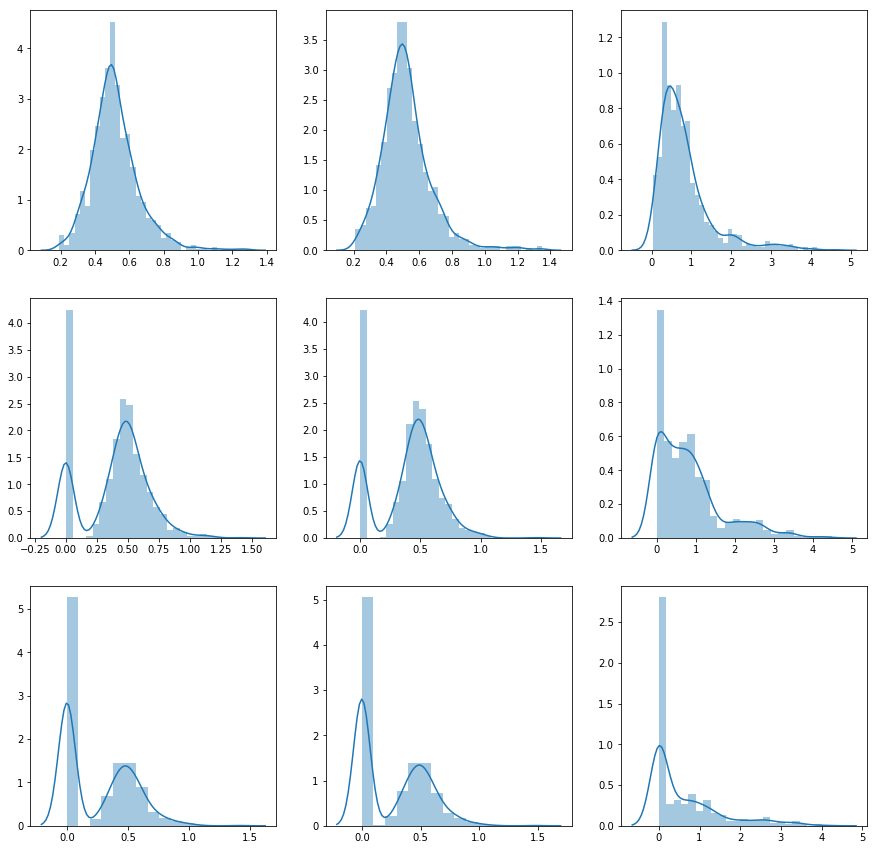

In [59]:
fig, axes = plt.subplots(3, 3, figsize = (15, 15))

sns.distplot(np.array(np.concatenate((test_1))), ax = axes[0,0])
sns.distplot(np.array(np.concatenate((test_2))), ax = axes[0,1])
sns.distplot(np.array(np.concatenate((test_3))), ax = axes[0,2])
sns.distplot(np.array(np.concatenate((test_4))), ax = axes[1,0])
sns.distplot(np.array(np.concatenate((test_5))), ax = axes[1,1])
sns.distplot(np.array(np.concatenate((test_6))), ax = axes[1,2])
sns.distplot(np.array(np.concatenate((test_7))), ax = axes[2,0])
sns.distplot(np.array(np.concatenate((test_8))), ax = axes[2,1])
sns.distplot(np.array(np.concatenate((test_9))), ax = axes[2,2])

In [4]:
#### Model definition
model_choice = 'wo_ls'
# With latent space
if model_choice == 'ls':
    net = model.create_model(input_shape, latent_dim, hidden_dim, filters, kernels, final_dim, conv_activation=None, dense_activation=None)
# Without latent space
if model_choice == 'wo_ls': # create_model_wo_ls
    net = model.create_model_wo_ls_multi(input_shape, latent_dim, hidden_dim, filters, kernels, final_dim, conv_activation=None, dense_activation=None)
# Full probabilistic model
if model_choice == 'full_prob':
    net = model.create_model_full_prob(input_shape, latent_dim, hidden_dim, filters, kernels, final_dim, conv_activation=None, dense_activation=None)
net.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 6)]       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 6)         24        
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 32)        1760      
_________________________________________________________________
p_re_lu (PReLU)              (None, 64, 64, 32)        131072    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 32, 32, 32)        32768     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496 

In [158]:
def numpy_fcn(x,y):
    x[y==0]=0
    return x

In [55]:
#### Loss definition
if model_choice == 'full_prob':
    kl = sum(net.losses)
    def loss(x, dists):
        nll = -dists.log_prob(x)
        print(nll)
        kl = sum(net.losses)
        print(kl)
        return nll + kl, collections.namedtuple('loss','nll,kl')(nll, kl)
    negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x) + kl *(10/(batch_size*steps_per_epoch)-1)

else:
    def loss(x, dists):
        mse = tf.keras.losses.MeanSquaredError()
        loss = 0
        for i in range(final_dim):
            loss += mse(dists[:,i], x[:,i])
        return loss

In [244]:
#### Loss definition
if model_choice == 'full_prob':
    kl = sum(net.losses)
    def loss(x, dists):
        nll = -dists.log_prob(x)
        print(nll)
        kl = sum(net.losses)
        print(kl)
        return nll + kl, collections.namedtuple('loss','nll,kl')(nll, kl)
    negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x) + kl *(10/(batch_size*steps_per_epoch)-1)

else:
    def loss(x, dists):
        mse = tf.keras.losses.MeanSquaredError()
        loss = 0
        
        a = tf.numpy_function(numpy_fcn, [tf.ones([100], tf.float32), tf.convert_to_tensor(x[:,6])], tf.float32)
        print(tf.math.squared_difference(dists[:,6], x[:,6]))
        print(a*tf.math.squared_difference(dists[:,6], x[:,6]))
        for i in range(final_dim):

            a = tf.numpy_function(numpy_fcn, [tf.ones([100], tf.float32), tf.convert_to_tensor(x[:,i])], tf.float32)
            loss += tf.reduce_mean(a*tf.math.squared_difference(dists.mean()[:,i], x[:,i]))#mse(a*dists[:,i], x[:,i])
        return loss

In [245]:
net.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3), 
              loss=loss , metrics = ['mse', 'acc'], experimental_run_tf_function=False)

Tensor("loss_46/multivariate_normal_tri_l_loss/SquaredDifference:0", shape=(None,), dtype=float32)
Tensor("loss_46/multivariate_normal_tri_l_loss/mul:0", dtype=float32)


In [246]:
output_gen = training_generator.__getitem__(2)

In [247]:
output_gen[0].shape, output_gen[1].shape

((100, 64, 64, 6), (100, 9))

In [248]:
out = net(output_gen[0])

In [249]:
out.shape

TensorShape([100, 9])

In [250]:
out.mean()[:,0]

<tf.Tensor: id=44919, shape=(100,), dtype=float32, numpy=
array([ 120.44876  ,    0.       ,    0.       ,   67.16374  ,
         67.31597  ,    7.269745 ,  601.2458   ,    0.       ,
          0.       ,  160.15216  ,    0.       ,  581.25305  ,
          0.       ,   24.038326 ,    9.825019 ,    0.       ,
          0.       ,    0.       ,  330.3306   ,  851.8134   ,
          0.       ,    0.       ,   23.520588 , 5736.814    ,
          0.       ,    6.909252 ,  246.00133  ,    0.       ,
          0.       ,  426.96735  ,    0.       ,    0.       ,
          0.       ,    0.       ,    0.       ,    0.       ,
          0.       ,    0.       ,    0.       ,   94.59921  ,
          0.       ,    0.       ,    0.       ,    0.       ,
          9.786209 ,    0.       ,    0.       ,    0.       ,
          0.       ,    0.       ,    0.       ,  168.86195  ,
          0.       ,  112.37687  ,    0.       ,  162.67291  ,
          0.       ,    0.       ,    0.       ,    0.      

In [253]:
output_gen[1][:,6]

array([0.        , 0.        , 0.        , 2.43462685, 1.26475631,
       0.        , 1.43136134, 2.82569438, 0.        , 1.97693151,
       0.        , 2.85568027, 0.        , 1.93093921, 1.77665791,
       0.        , 0.        , 0.        , 0.        , 2.32728051,
       2.51568586, 0.        , 0.        , 2.1352878 , 1.58556154,
       1.23519334, 0.        , 1.73603572, 0.        , 2.75683914,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.74726171, 2.91791675, 0.        ,
       1.83240431, 1.29506644, 0.        , 2.09693051, 2.37737249,
       2.24221799, 1.90922475, 2.35461801, 0.        , 1.53732181,
       2.09935186, 2.32600093, 0.        , 0.        , 0.        ,
       2.91625688, 2.62304023, 0.        , 1.33493704, 0.        ,
       2.41319223, 3.04255937, 1.65124787, 2.72552843, 3.042251  ,
       2.07789342, 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.9231402 , 0.        , 0.        , 2.04415

In [254]:
loss(output_gen[1], out)

tf.Tensor(
[6.5288500e+05 2.4356442e+05 8.2501977e+04 4.7720441e+04 3.4274356e+05
 2.4173436e+04 5.1109754e+04 4.0243895e+04 1.1962211e+05 1.9114895e+04
 1.0651352e+04 1.4422552e+05 1.5970730e+06 3.7528266e+04 2.1144260e+04
 9.4929938e+04 3.1274797e+03 5.4318110e+03 3.4009834e+05 8.0458828e+03
 8.6189825e+05 4.0413305e+04 1.1973628e+04 1.1912888e+07 2.3656178e+04
 6.9168281e+04 1.6230645e+05 1.8816910e+06 6.5254326e+03 8.0992175e+05
 1.7984181e+05 2.9581103e+05 4.8329683e+03 1.6380754e+03 6.3961812e+03
 4.9972550e+05 2.8814347e+05 3.4299992e+04 3.2536538e+05 1.6131282e+06
 1.5158527e+04 2.4438803e+05 3.0948794e+05 1.0747566e+08 5.0286160e+02
 2.8312520e+04 3.8941431e+05 1.2186572e+06 1.6060526e+04 1.8528217e+04
 7.5254883e+04 1.4467570e+06 1.3621053e+05 2.1014911e+05 1.5024848e+05
 9.9081523e+03 8.8324617e+04 4.2051394e+05 2.2406331e+05 1.1802981e+04
 4.6693336e+04 1.5040711e+05 4.8465850e+05 1.0620540e+06 6.0701135e+06
 5.4144614e+03 2.8304303e+05 3.2500341e+05 1.4180814e+05 8.0734870

<tf.Tensor: id=45227, shape=(), dtype=float32, numpy=2003321.5>

In [235]:
mse = tf.keras.losses.MeanSquaredError()
loss = mse(out[:,0], output_gen[1][:,0])
print(loss)

tf.Tensor(156237.890625, shape=(), dtype=float64)


In [205]:
out[:,0][0]-output_gen[1][:,0][0]

<tf.Tensor: id=40486, shape=(), dtype=float32, numpy=-0.41115904>

In [206]:
output_gen[1][:,5]

array([0.        , 0.        , 0.53119999, 0.        , 0.63150001,
       0.62110001, 0.65170002, 0.73640001, 0.        , 0.65499997,
       0.38839999, 0.        , 0.        , 1.12880003, 0.85460001,
       1.17840004, 0.76550001, 0.        , 0.92610002, 0.23010001,
       1.08340001, 3.2434001 , 2.3355999 , 0.        , 2.17070007,
       0.78320003, 2.45079994, 0.        , 0.        , 2.4066    ,
       0.5887    , 1.29910004, 0.        , 0.        , 1.53429997,
       0.        , 1.1832    , 0.        , 1.25989997, 0.41929999,
       0.        , 0.        , 0.        , 0.        , 0.96359998,
       0.4163    , 0.        , 0.41240001, 1.23010004, 2.12709999,
       1.71819997, 0.8071    , 1.68219995, 0.97939998, 0.        ,
       0.37099999, 1.83340001, 0.        , 0.        , 0.26800001,
       4.71869993, 0.48359999, 0.65219998, 2.66700006, 0.73390001,
       0.        , 0.361     , 0.20469999, 0.28749999, 2.27929997,
       0.1913    , 0.92989981, 0.        , 1.77400005, 0.     

In [207]:
a = np.ones((100))
a[output_gen[1][:,5]==0]=0
print(a)

[0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0.
 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1.
 1. 0. 1. 0.]


In [50]:
a*output_gen[1][:,5]

array([0.        , 1.31980002, 1.23020005, 1.46389997, 0.54040003,
       1.96379995, 0.        , 0.        , 0.30849999, 3.53970003,
       0.        , 0.51370001, 0.        , 0.42320001, 0.47909999,
       1.08420002, 0.44980001, 0.        , 1.24800003, 1.25090003,
       0.53320003, 0.74150002, 0.65789998, 0.95920002, 0.745     ,
       0.        , 1.09080005, 1.69120002, 0.        , 1.28269994,
       1.13750005, 0.65649998, 0.76800001, 0.37349999, 1.36670005,
       0.        , 0.        , 1.17700005, 0.54769999, 0.5072    ,
       0.        , 0.43900001, 0.        , 1.12380004, 0.42629999,
       0.        , 1.34019995, 0.99860001, 0.        , 0.96310002,
       0.59170002, 3.01169991, 0.3114    , 0.3572    , 0.        ,
       0.1389    , 1.102     , 2.05940008, 0.        , 1.03069997,
       0.56870002, 1.60959995, 0.58939999, 0.        , 0.        ,
       0.86900002, 0.67180002, 0.2062    , 0.55070001, 0.3312    ,
       0.74070001, 0.67739999, 0.68830001, 0.        , 0.     

In [51]:
a*np.ones((100))

array([0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1.,
       1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1.,
       0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1.])

In [14]:
out[:,0]

<tf.Tensor: id=790, shape=(100,), dtype=float32, numpy=
array([ 3.69066772e+01,  3.39415710e+02,  3.44805725e+02,  7.50777359e+01,
        5.78050346e+01, -2.82469415e-03, -4.88606602e-01,  9.35387497e+01,
       -2.03814068e+01,  2.44932938e+02,  1.76271744e+02, -8.89910161e-01,
        6.75783992e-01,  3.50118011e-01,  1.49429749e+03,  5.35632253e-01,
        3.32552834e+01,  4.03296700e+01,  1.02944695e+02,  5.04831135e-01,
       -1.44285830e-02,  1.28350675e+00,  1.28119504e+00, -3.63215820e+02,
        2.41852097e+02, -4.92380738e-01,  1.45497522e+01,  5.07986816e+02,
       -3.04148737e-02, -3.35347652e-02, -3.01782131e-01, -1.78311970e-02,
        2.52956040e-02,  3.17429474e+02, -3.86724383e-01,  5.63173866e+01,
       -1.07196423e+03,  3.63836974e-01,  1.03067088e+00, -3.73538047e-01,
        1.42455762e+03,  3.00773804e+02,  4.80793266e+01,  1.38414764e+02,
       -7.20186949e-01, -2.84404665e-01,  3.77850056e-01,  9.37060318e+01,
        1.97219391e+02, -1.56357346e+02,  4.

In [ ]:
loading_path = '/sps/lsst/users/barcelin/TFP/weights/blended_multi_3/loss/'
latest = tf.train.latest_checkpoint(loading_path)
net.load_weights(latest)



# Callbacks
saving_path = '/sps/lsst/users/barcelin/TFP/weights/blended_multi_3/'
checkpointer_mse = tf.keras.callbacks.ModelCheckpoint(filepath=saving_path+'mse/weights_noisy_v4.{epoch:02d}-{val_mse:.2f}.ckpt', monitor='val_mse', verbose=1, save_best_only=True,save_weights_only=True, mode='min', period=1)
checkpointer_loss = tf.keras.callbacks.ModelCheckpoint(filepath=saving_path+'loss/weights_noisy_v4.{epoch:02d}-{val_loss:.2f}.ckpt', monitor='val_loss', verbose=1, save_best_only=True,save_weights_only=True, mode='min', period=1)
checkpointer_acc = tf.keras.callbacks.ModelCheckpoint(filepath=saving_path+'acc/weights_noisy_v4.{epoch:02d}-{val_acc:.2f}.ckpt', monitor='val_acc', verbose=1, save_best_only=True,save_weights_only=True, mode='max', period=1)

callbacks = [checkpointer_mse, checkpointer_loss, checkpointer_acc]

In [ ]:
######## Train the network
hist = net.fit_generator(training_generator, epochs=200, # training
          steps_per_epoch=steps_per_epoch,#128
          verbose=1,
          shuffle=True,
          validation_data=validation_generator, # validation
          validation_steps=validation_steps,#16
          callbacks= callbacks,
          workers=0,#4 
          use_multiprocessing = True)

In [ ]:
saving_path = '/sps/lsst/users/barcelin/TFP/weights/blended_multi_3/'
net.save_weights(saving_path+'cp-{epoch:04d}.ckpt')
# 2 galaxies dans /weights/blended_multi/


## Plots
loading_path = '/sps/lsst/users/barcelin/TFP/weights/blended_multi_3/loss/'
latest = tf.train.latest_checkpoint(loading_path)
net.load_weights(latest)


test = test_generator.__getitem__(2)

training_data = test[0]
training_labels = test[1]
out = net(training_data)

fig = plt.figure()
sns.distplot(out.mean().numpy()[:,0], bins = 20)
sns.distplot(training_labels[:,0], bins = 20)
fig.savefig('test_distrib_e1.png')


fig = plt.figure()
sns.distplot(out.mean().numpy()[:,1], bins = 20)
sns.distplot(training_labels[:,1], bins = 20)
fig.savefig('test_distrib_e2.png')


fig = plt.figure()
sns.distplot(out.mean().numpy()[:,2], bins = 20)
sns.distplot(training_labels[:,2], bins = 20)
fig.savefig('test_distrib_z.png')

fig = plt.figure()
sns.distplot(out.mean().numpy()[:,3], bins = 20)
sns.distplot(training_labels[:,3], bins = 20)
fig.savefig('test_distrib_e1_2.png')


fig = plt.figure()
sns.distplot(out.mean().numpy()[:,4], bins = 20)
sns.distplot(training_labels[:,4], bins = 20)
fig.savefig('test_distrib_e2_2.png')


fig = plt.figure()
sns.distplot(out.mean().numpy()[:,5], bins = 20)
sns.distplot(training_labels[:,5], bins = 20)
fig.savefig('test_distrib_z_2.png')

fig = plt.figure()
sns.distplot(out.mean().numpy()[:,6], bins = 20)
sns.distplot(training_labels[:,6], bins = 20)
fig.savefig('test_distrib_e1_3.png')


fig = plt.figure()
sns.distplot(out.mean().numpy()[:,7], bins = 20)
sns.distplot(training_labels[:,7], bins = 20)
fig.savefig('test_distrib_e2_3.png')


fig = plt.figure()
sns.distplot(out.mean().numpy()[:,8], bins = 20)
sns.distplot(training_labels[:,8], bins = 20)
fig.savefig('test_distrib_z_3.png')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(training_labels[:,0], out.mean().numpy()[:,0], '.', label = 'mean')
axes[0].plot(training_labels[:,0], out.mean().numpy()[:,0]+ 2*out.stddev().numpy()[:,0], '+', label = 'mean + 2stddev')
axes[0].plot(training_labels[:,0], out.mean().numpy()[:,0]- 2*out.stddev().numpy()[:,0], '+', label = 'mean - 2stddev')
#x = np.linspace(-1,1)
x = np.linspace(0,5)
axes[0].plot(x, x)
axes[0].legend()
#axes[0].set_ylim(-1,1)
axes[1].set_ylim(0,5)
axes[0].set_title('$e1$')

axes[1].plot(training_labels[:,1], out.mean().numpy()[:,1], '.', label = 'mean')
axes[1].plot(training_labels[:,1], out.mean().numpy()[:,1]+ 2*out.stddev().numpy()[:,1], '+', label = 'mean + 2stddev')
axes[1].plot(training_labels[:,1], out.mean().numpy()[:,1]- 2*out.stddev().numpy()[:,1], '+', label = 'mean - 2stddev')
#x = np.linspace(-1,1)
x = np.linspace(0,5)
axes[1].plot(x, x)
axes[1].legend()
#axes[1].set_ylim(-1,1)
axes[1].set_ylim(0,5)
axes[1].set_title('$e2$')

axes[2].plot(training_labels[:,2], out.mean().numpy()[:,2], '.', label = 'mean')
axes[2].plot(training_labels[:,2], out.mean().numpy()[:,2]+ 2*out.stddev().numpy()[:,2], '+', label = 'mean + 2stddev')
axes[2].plot(training_labels[:,2], out.mean().numpy()[:,2]- 2*out.stddev().numpy()[:,2], '+', label = 'mean - 2stddev')
x = np.linspace(0,4)
axes[2].plot(x, x)
axes[2].legend()
axes[2].set_ylim(-1,5.5)
axes[2].set_title('$z$')

fig.savefig('test_train.png')


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(training_labels[:,3], out.mean().numpy()[:,3], '.', label = 'mean')
axes[0].plot(training_labels[:,3], out.mean().numpy()[:,3]+ 2*out.stddev().numpy()[:,3], '+', label = 'mean + 2stddev')
axes[0].plot(training_labels[:,3], out.mean().numpy()[:,3]- 2*out.stddev().numpy()[:,3], '+', label = 'mean - 2stddev')
#x = np.linspace(-1,1)
x = np.linspace(0,5)
axes[0].plot(x, x)
axes[0].legend()
#axes[0].set_ylim(-1,1)
axes[1].set_ylim(0,5)
axes[0].set_title('$e1$')

axes[1].plot(training_labels[:,4], out.mean().numpy()[:,4], '.', label = 'mean')
axes[1].plot(training_labels[:,4], out.mean().numpy()[:,4]+ 2*out.stddev().numpy()[:,4], '+', label = 'mean + 2stddev')
axes[1].plot(training_labels[:,4], out.mean().numpy()[:,4]- 2*out.stddev().numpy()[:,4], '+', label = 'mean - 2stddev')
#x = np.linspace(-1,1)
x = np.linspace(0,5)
axes[1].plot(x, x)
axes[1].legend()
#axes[1].set_ylim(-1,1)
axes[1].set_ylim(0,5)
axes[1].set_title('$e2$')

axes[2].plot(training_labels[:,5], out.mean().numpy()[:,5], '.', label = 'mean')
axes[2].plot(training_labels[:,5], out.mean().numpy()[:,5]+ 2*out.stddev().numpy()[:,5], '+', label = 'mean + 2stddev')
axes[2].plot(training_labels[:,5], out.mean().numpy()[:,5]- 2*out.stddev().numpy()[:,5], '+', label = 'mean - 2stddev')
x = np.linspace(0,4)
axes[2].plot(x, x)
axes[2].legend()
axes[2].set_ylim(-1,5.5)
axes[2].set_title('$z$')
fig.savefig('test_train_2.png')


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(training_labels[:,6], out.mean().numpy()[:,6], '.', label = 'mean')
axes[0].plot(training_labels[:,6], out.mean().numpy()[:,6]+ 2*out.stddev().numpy()[:,6], '+', label = 'mean + 2stddev')
axes[0].plot(training_labels[:,6], out.mean().numpy()[:,6]- 2*out.stddev().numpy()[:,6], '+', label = 'mean - 2stddev')
#x = np.linspace(-1,1)
x = np.linspace(0,5)
axes[0].plot(x, x)
axes[0].legend()
#axes[0].set_ylim(-1,1)
axes[1].set_ylim(0,5)
axes[0].set_title('$e1$')

axes[1].plot(training_labels[:,7], out.mean().numpy()[:,7], '.', label = 'mean')
axes[1].plot(training_labels[:,7], out.mean().numpy()[:,7]+ 2*out.stddev().numpy()[:,7], '+', label = 'mean + 2stddev')
axes[1].plot(training_labels[:,7], out.mean().numpy()[:,7]- 2*out.stddev().numpy()[:,7], '+', label = 'mean - 2stddev')
#x = np.linspace(-1,1)
x = np.linspace(0,5)
axes[1].plot(x, x)
axes[1].legend()
#axes[1].set_ylim(-1,1)
axes[1].set_ylim(0,5)
axes[1].set_title('$e2$')

axes[2].plot(training_labels[:,8], out.mean().numpy()[:,8], '.', label = 'mean')
axes[2].plot(training_labels[:,8], out.mean().numpy()[:,8]+ 2*out.stddev().numpy()[:,8], '+', label = 'mean + 2stddev')
axes[2].plot(training_labels[:,8], out.mean().numpy()[:,8]- 2*out.stddev().numpy()[:,8], '+', label = 'mean - 2stddev')
x = np.linspace(0,4)
axes[2].plot(x, x)
axes[2].legend()
axes[2].set_ylim(-1,5.5)
axes[2].set_title('$z$')
fig.savefig('test_train_3.png')